In [1]:
import PIL
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tqdm import tqdm

In [2]:
# easily aligned tall skinny patch of random noise
column_dims = (1024, 256)
column_height, column_width = column_dims

palettes = {
    "Grayscale": ["#000000", "#555555", "#AAAAAA", "#DDDDDD", "#FFFFFF"],
    "Cool Tones": ["#001f3f", "#0074D9", "#7FDBFF", "#39CCCC", "#3D9970"],
    "Warm Tones": ["#85144b", "#FF4136", "#FF851B", "#FFDC00", "#3D9970"],
    "Earth Tones": ["#8B4513", "#6B8E23", "#F5F5DC", "#F0E68C", "#006400"],
    "Pastel": ["#FFB6C1", "#ADD8E6", "#90EE90", "#E6E6FA", "#FFDAB9"],
    "Monochromatic Blue": ["#001f3f", "#4169E1", "#87CEEB", "#ADD8E6", "#B0E0E6"],
    "Retro": ["#FFDB58", "#B7410E", "#808000", "#3EB489", "#F5F5DC"],
}


# Function to apply palette to random values
def apply_palette(values, palette):
    colormap = [mcolors.hex2color(palette[v]) for v in values.flatten()]
    colormap = np.array(colormap).reshape(values.shape + (3,))
    return colormap


values = np.random.randint(0, 5, column_dims)

column = apply_palette(values, palettes["Warm Tones"])

# # plot the column at full resolution
# fig, ax = plt.subplots(dpi=256)
# ax.imshow(column)
# ax.axis('off')
# plt.show()

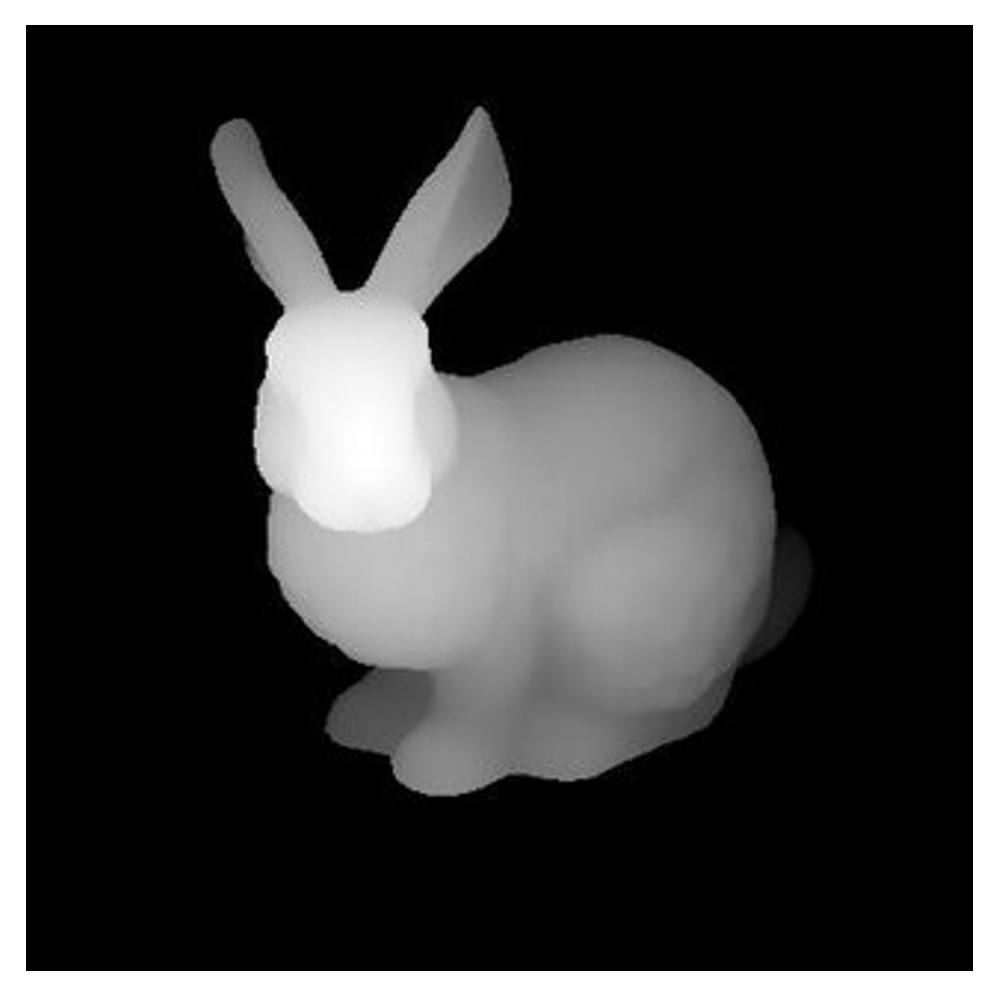

In [3]:
DEPTH_MAP = "rabbit.jpg"  # 'elephant.png'

img = PIL.Image.open(DEPTH_MAP)
img = img.resize((column_height, column_height)).convert("L")

depth = np.array(img)
depth = depth / 255.0

# plot the depth map
fig, ax = plt.subplots(dpi=256)
ax.imshow(depth, cmap="gray")
ax.axis("off")
plt.show()

In [4]:
SHIFT_RANGE = 0.3

output_values = np.zeros(depth.shape, dtype=int)
# write the noise to the first column of output
output_values = np.hstack((values, output_values))

for y in range(output_values.shape[0]):  # for each row
    for x in range(
        output_values.shape[1]
    ):  # for each pixel which must be assigned a value in that row
        if x < column_dims[1]:  # if we're still in the first column
            continue

        depth_value = depth[
            y, x - column_width
        ]  # depth from 0 to 1 of the output pixel in the depth map

        shift = column_width - (depth_value * SHIFT_RANGE * column_width)

        shifted_x = x - shift

        interpolated_value = np.random.choice(
            [
                output_values[y, int(np.floor(shifted_x))],
                output_values[y, int(np.ceil(shifted_x))],
            ],
            p=[1 - (shifted_x % 1.0), shifted_x % 1.0],
        )

        output_values[y, x] = interpolated_value

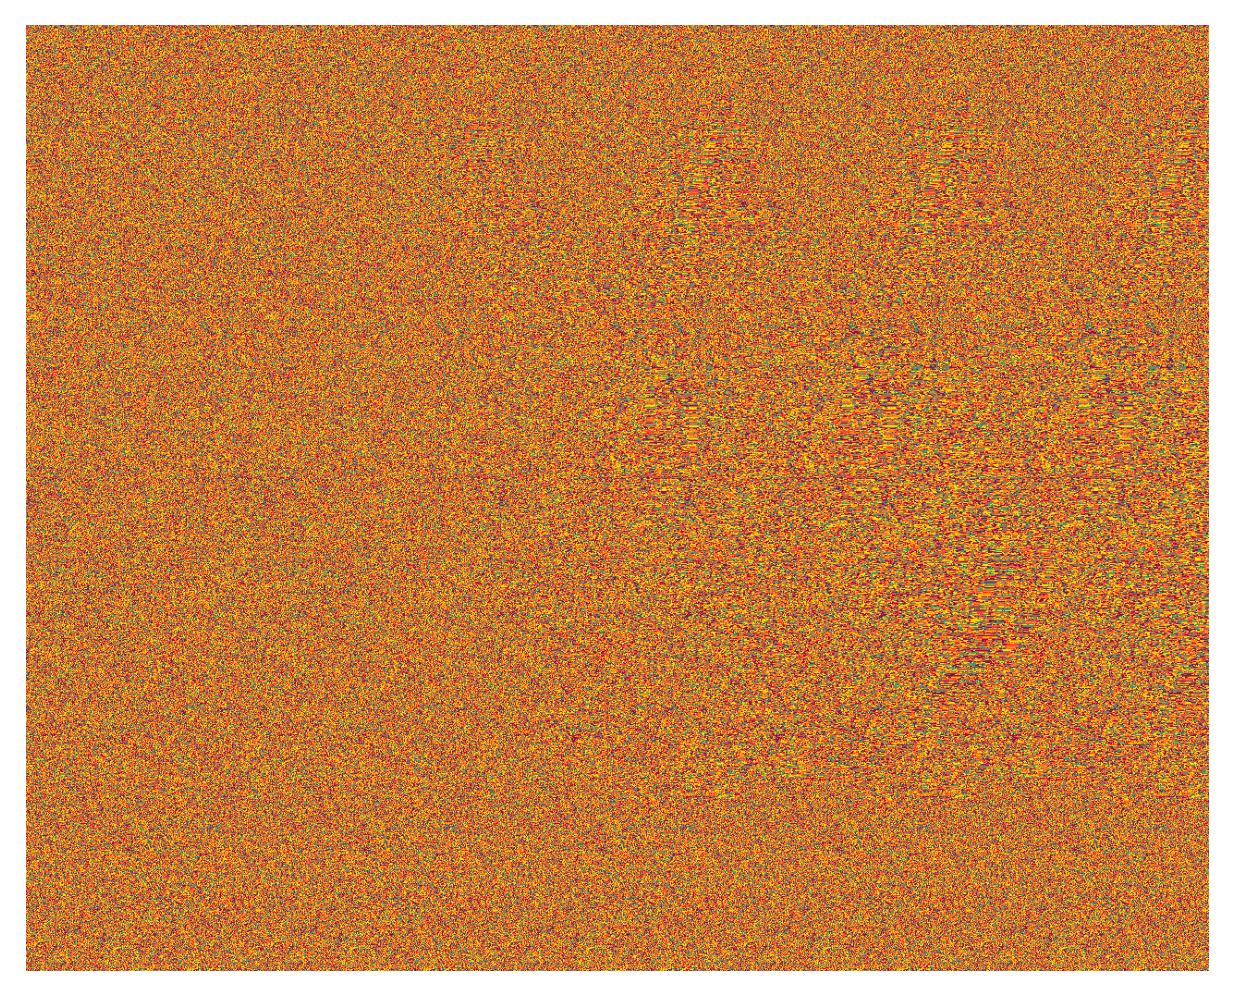

In [5]:
output = apply_palette(output_values, palettes["Warm Tones"])

fig, ax = plt.subplots(dpi=256)
ax.imshow(output)
ax.axis("off")
# fig.savefig('output.png', bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

Generating points: 100%|██████████| 10000/10000 [00:01<00:00, 7601.08it/s]


(10000, 3)
(84201, 3)
[0.41124724 0.2027547  0.92315961]


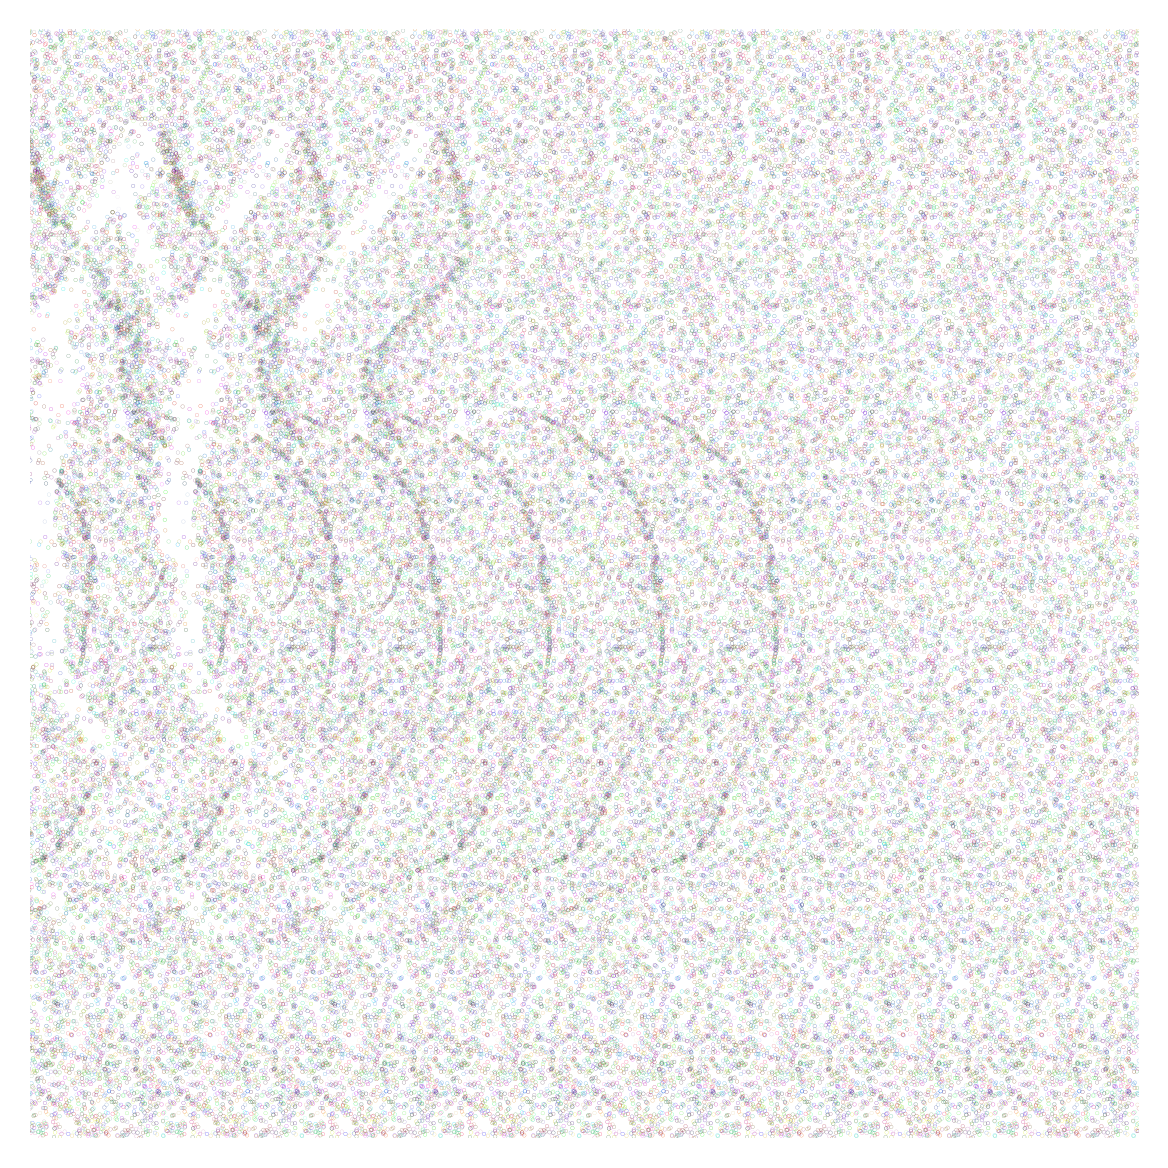

In [13]:
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path
import matplotlib.patches as patches

def map_back(
    x: float,
    y: float,
    interpolated_depth_map: RegularGridInterpolator,
    column_width: float,
    shift_range: float,
) -> float:
    """Gives the x coordinate of the repetition of the point (x, y) in the depth map to the left of the point (x, y)"""
    depth_value = interpolated_depth_map([x, y])[0]
    return x - column_width * (1 - depth_value * shift_range)


def magic_eye_with_patches(
    depth_map: Path, column_dims: tuple[int, int], shift_range: float, n_points: int
) -> np.ndarray:
    """generates a magic eye image with patches instead of raster pixels

    Args:
        depth_map: path to the depth map image
        column_dims: dimensions of the column [x_max, y_max]
        shift_range: proportion of the column width that the depth map can shift a point
        n_points: number of points to sample in the initial column
    """
    column_width, column_height = column_dims
    
    depth_map = PIL.Image.open(depth_map)
    if type(depth_map) == PIL.PngImagePlugin.PngImageFile:
        depth_map = depth_map.convert("L")
    # resizing to get the depth map to remain the same aspect ratio while being column_height tall
    depth_map = depth_map.resize((column_height, round(depth_map.width * column_height / depth_map.height)))
    depth_map = np.array(depth_map)
    depth_map = depth_map / 255.0

    points = np.random.rand(n_points, 2)
    colors = np.random.rand(n_points, 3)
    
    # scaling the x and y coordinates to the column dimensions
    points[:, 0] = points[:, 0] * column_width
    points[:, 1] = points[:, 1] * column_height
    
    # translating the points to be the left-most column
    points[:, 0] = points[:, 0] + (column_height - column_width)
    
    interpolated_depth_map = RegularGridInterpolator((np.linspace(0, depth_map.shape[1], depth_map.shape[1]), np.linspace(0, depth_map.shape[0], depth_map.shape[0])), depth_map.T)
    new_points = []
    for point, color in tqdm(zip(points, colors), desc="Generating points", total=len(points)):
        x = point[0]
        while x > 0:
            x = map_back(x, point[1], interpolated_depth_map, column_width, shift_range)
            new_points.append(((x, point[1]), color))
    
    new_points_array = np.array([point for point, _ in new_points])
    new_colors_array = np.array([color for _, color in new_points])
    points = np.vstack((points, new_points_array))
    print(colors.shape)
    print(new_colors_array.shape)
    print(new_colors_array[0])
    colors = np.vstack((colors, new_colors_array))
    
    # plot the image
    fig, ax = plt.subplots(dpi=300)
    
    # generate the patches for each point
    ax.scatter(points[:, 0], points[:, 1], edgecolor=colors, s=3, facecolor="none", marker=".", linewidths=0.05)
    
    # for point, color in tqdm(zip(points, colors), desc="Generating patches", total=len(points)):
    #     ax.add_patch(patches.Circle(point, 1, edgecolor=color, facecolor="none", linewidth=0.05))
    
    ax.axis("off")
    ax.set_aspect("equal")
    
    ax.set_xlim(0, depth_map.shape[1])
    ax.set_ylim(0, depth_map.shape[0])
    ax.invert_yaxis() # plot coordinates are from the bottom left, but image coordinates are from the top left
    
    plt.show()
    
magic_eye_with_patches(Path("rabbit.jpg"), (128, 1024), 0.3, 10000)

In [7]:
# 

*the periodicity of the column is convenient but not actually necessary?*

without the column there's dissonance where left points land and there's no other one to continue the pattern.